# Using Machine Learning in a hospital context to predict patient satisfaction

### Loading the packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report, recall_score, confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE

## 1. Reading in the data

In [2]:
df = pd.read_csv('../data/Dataset Hospital Case.csv').set_index('SN')
df.head() # We take a look at the first 5 rows of the dataset 

,MaritalStatus,AgeYrs,Gender,BedCategory,Department,Estimatedcost,CE_ACCESSIBILITY,CE_VALUEFORMONEY,EM_IMMEDIATEATTENTION,EM_NURSING,...,OVS_OVERALLSTAFFPROMPTNESS,OVS_SECURITYATTITUDE,DP_DISCHARGETIME,DP_DISCHARGEQUERIES,DP_DISCHARGEPROCESS,AdmissionDate,DischargeDate,LengthofStay,NPS_Score,NPS_Status
SN,,,,,,,,,,,,,,,,,,,,,
1,Single,4.0,F,SPECIAL,PEDIATRIC,25000.0,4,4,4,4,...,4,4,4,4,4,18/07/2014,21/07/2014,3,9,Promotor
2,Single,13.0,F,SPECIAL,PEDIATRIC,15000.0,4,4,4,4,...,4,4,4,4,4,11/07/2014,16/07/2014,5,10,Promotor
3,Married,33.0,F,SEMISPECIAL,GYNAEC,70000.0,3,2,4,4,...,4,4,3,4,3,17/06/2014,20/07/2014,33,7,Passive
4,Married,51.0,F,SPECIAL,GYNAEC,150000.0,4,3,4,4,...,3,3,3,4,3,16/07/2014,22/07/2014,6,10,Promotor
5,Married,31.0,F,SPECIAL,GYNAEC,100000.0,4,4,4,4,...,4,4,4,4,4,13/07/2014,16/07/2014,3,10,Promotor


In [3]:
# We create a new dataframe to put the background variables in
df_background = df[["Department", "AgeYrs", "Gender", "MaritalStatus","BedCategory", "Estimatedcost"
                  ,"AdmissionDate", "DischargeDate","LengthofStay"]]

# We remove all the instances that are passives
df = df[df['NPS_Status'] != 'Passive']

# We drop the background and target variables from our survey dataframe. It now only contains the features.
df_survey= df.drop(df_background.columns, axis=1)
df_survey = df_survey.drop(['NPS_Score','NPS_Status'], axis = 1) 

# We define our target dataframe
df_target = df['NPS_Status'] 

## 2. Exploratory data analysis (EDA)

### Target variable: absolute and relative count

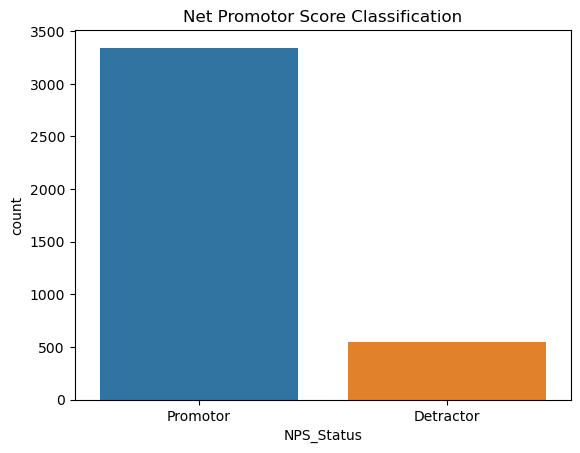

In [4]:
sns.countplot(x = df_target)
plt.title('Net Promotor Score Classification');

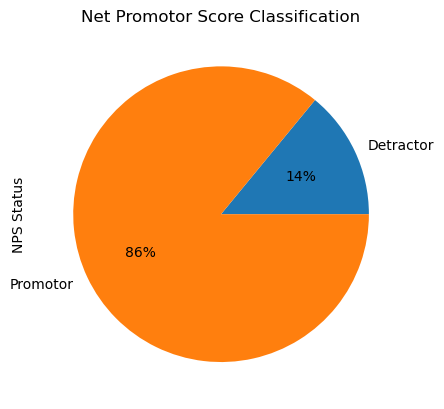

In [5]:
# Plot this in a piechart 
df.groupby('NPS_Status').size()\
    .plot(kind='pie', autopct='%1.0f%%')\
    .set_ylabel('NPS Status')
plt.title('Net Promotor Score Classification');

### Explore the features  

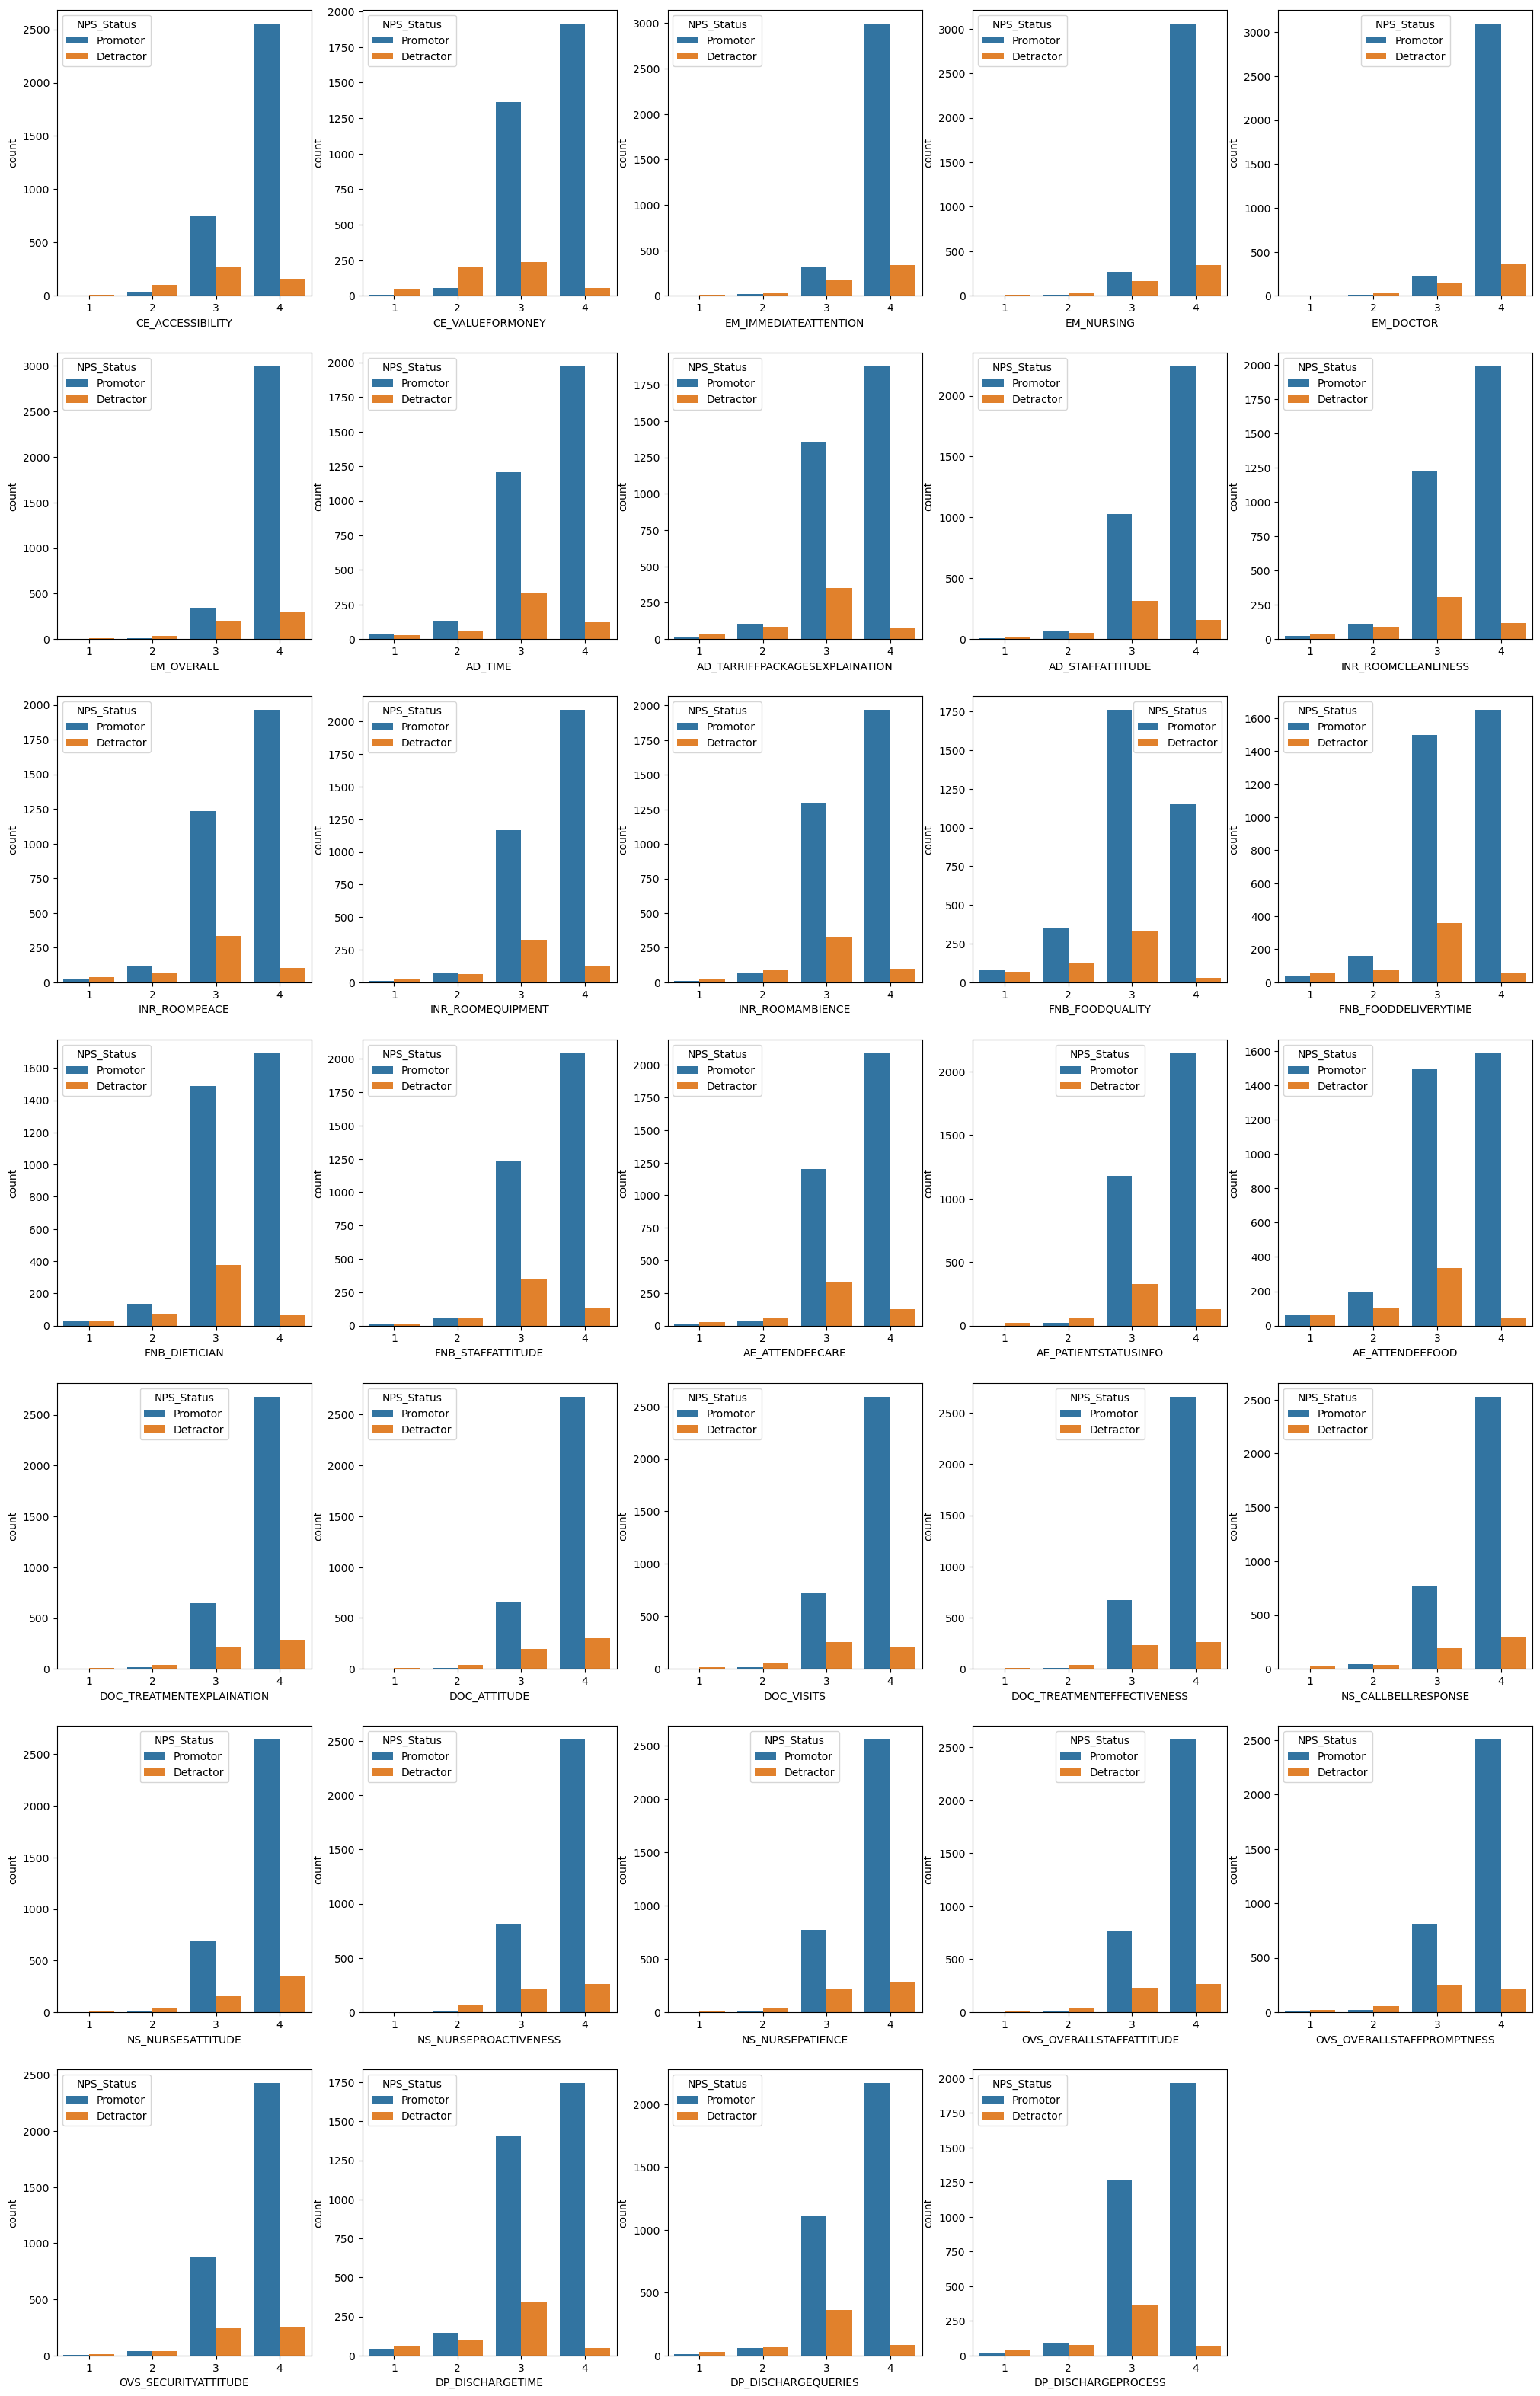

In [6]:
fig = plt.figure(figsize=(25,40)) 

for i, col in enumerate(df_survey): 
    plt.subplot(7, 5, i+1)
    sns.countplot(x=df_survey[col], hue=df_target) 

### Treating the data imbalance

Perform the <a href=https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html>`train_test_split`</a> on our 'new' dataset 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df_survey, df_target, test_size=0.2, random_state=42, 
    stratify=df_target)

Apply **SMOTE** to over-sample the *detractor* classes

In [8]:
# We make sure that our dataset is a balanced dataset 
sm = SMOTE(random_state=0)
X_train, y_train = sm.fit_resample(X_train,y_train)


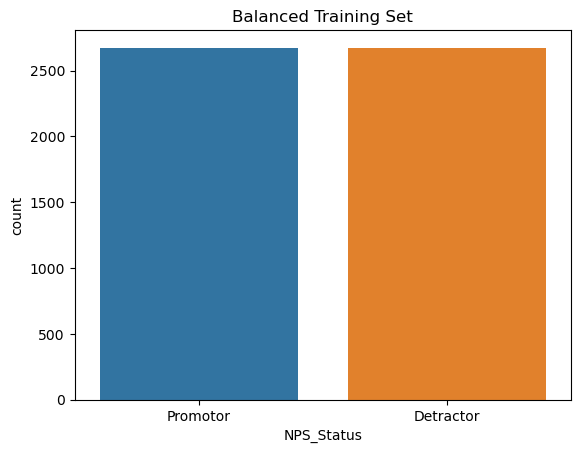

In [9]:
sns.countplot(x = y_train)
plt.title('Balanced Training Set');

## 3. Predictive modeling

### Logistic Regression

In [10]:
# Define a logistic regression classifier
LR = LogisticRegression(solver='newton-cg', max_iter=500)
# Fit the classifier on the training data
LR = LR.fit(X_train, y_train)
y_pred= LR.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Detractor       0.45      0.76      0.57       109
    Promotor       0.96      0.85      0.90       669

    accuracy                           0.84       778
   macro avg       0.70      0.81      0.73       778
weighted avg       0.89      0.84      0.85       778



### Confusion Matrix

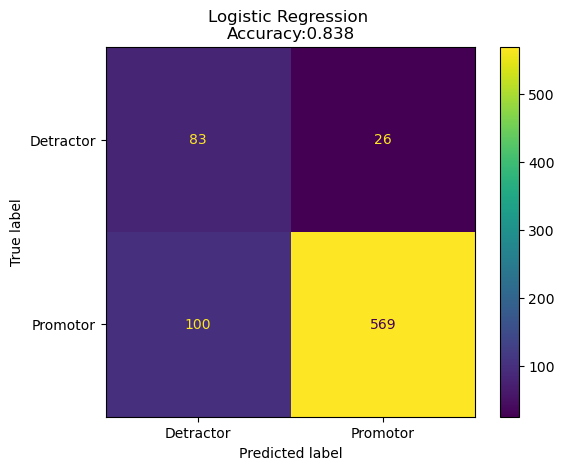

In [11]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR.classes_)
disp.plot()
plt.title('Logistic Regression \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)));

### Decision Tree

In [12]:
# Create a decision tree classifier 
DT = DecisionTreeClassifier(random_state = 0)
# Fit the classifier on the balanced training data
DT = DT.fit(X_train,y_train)
y_pred = DT.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Detractor       0.54      0.66      0.60       109
    Promotor       0.94      0.91      0.93       669

    accuracy                           0.87       778
   macro avg       0.74      0.78      0.76       778
weighted avg       0.89      0.87      0.88       778



### Confusion Matrix

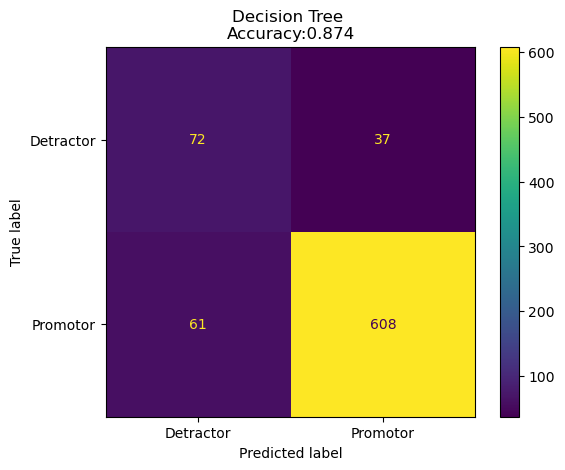

In [13]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DT.classes_)
disp.plot()
plt.title('Decision Tree \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)));

### Summary Performance Metrics

###### Logistic regression

Accuracy: 0.83 <br>
Precision: 0.81<br>
Recall: 0.83<br>
F-score: 0.82

###### Decision tree

Accuracy: 0.92 <br>
Precision: 0.92<br>
Recall: 0.91<br>
F-score: 0.92
    


###### Random forest
    
Accuracy: 0.94 <br>
Precision: 0.93 <br>
Recall: 0.95 <br>
F-score: 0.94 <br>



###### Gradient boosting
    
Accuracy: 0.88 <br>
Precision: 0.87 <br>
Recall: 0.88 <br>
F-score: 0.88 <br>


## 4. Feature importance: Key drivers of NPS

Goal: Determine which <u>*features*</u> have a **significant impact** on the NPS status

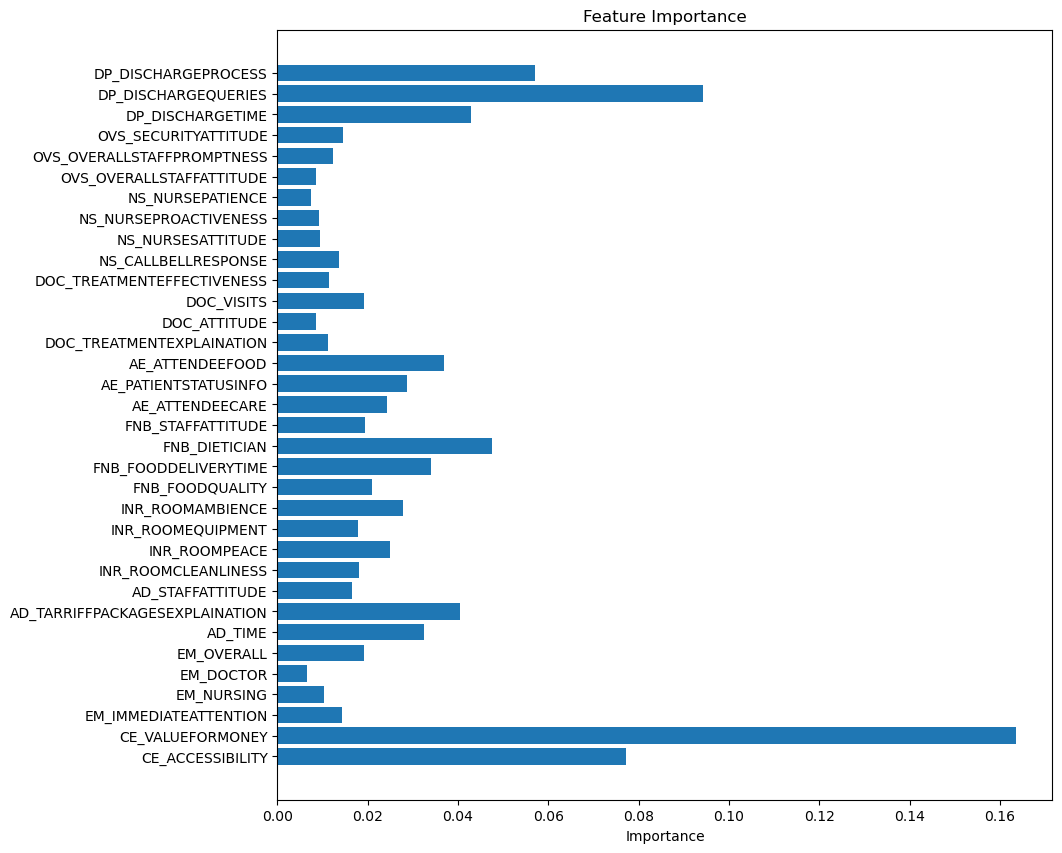

In [14]:
# Define your classifier
clf = RandomForestClassifier(random_state = 0)
# Fit classifier on your train data
clf = clf.fit(X_train,y_train)
# Save the feature importance
importance = clf.feature_importances_

# Plot feature importance
fig = plt.figure(figsize = (10,10))
plt.barh(X_train.columns, importance)
plt.title('Feature Importance')
plt.xlabel('Importance') 
plt.show()